In [41]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random

In [42]:
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [43]:
from tensorflow.keras.datasets import fashion_mnist

In [44]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [45]:
x_train.shape

(60000, 28, 28)

In [46]:
x_test.shape

(10000, 28, 28)

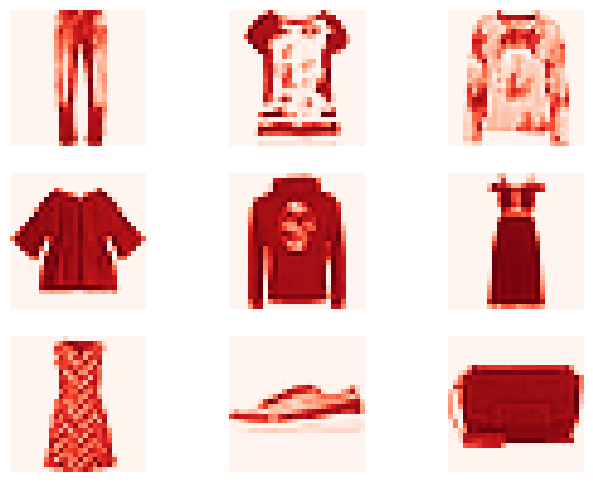

In [47]:
plt.figure(figsize = (8, 6))

random_samples = np.random.choice(60000, 9)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[random_samples[i]], cmap = "Reds")
    plt.axis("off")
plt.show()

In [48]:
data = np.concatenate([x_train, x_test], axis = 0)
data = np.expand_dims(data, -1).astype("float32") / 255

In [49]:
from tensorflow import keras
from tensorflow.keras import layers

In [50]:
class SamplingLayer(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape = (batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [51]:
def build_encoder(latent_dims, encoder_inputs):
    l_1 = keras.models.Sequential(
        [
            layers.Conv2D(128, 3, activation = "relu", strides = 2, padding = "same"),
            layers.Conv2D(64, 3, activation = "relu", strides = 2, padding = "same"),
            layers.Flatten(),
            layers.Dense(256, activation = "relu"),
        ]
    )
    
    x = l_1(encoder_inputs)
    zmean = layers.Dense(latent_dims, name = "z_mean")(x)
    zlogvar = layers.Dense(latent_dims, name = "z_log_var")(x)
    z = SamplingLayer()([zmean, zlogvar])

    return keras.Model(encoder_inputs, [zmean, zlogvar, z], name = "encoder")
    

In [52]:
encoder_inputs = keras.Input(shape = (28,28,1))
encoder = build_encoder(2, encoder_inputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_4 (Sequential)      (None, 256)          878144      ['input_5[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 2)            514         ['sequential_4[0][0]']           
                                                                                                  
 z_log_var (Dense)              (None, 2)            514         ['sequential_4[0][0]']           
                                                                                            

In [53]:
def build_decoder(latent_inputs):
    l_2 =  keras.models.Sequential(
        [
            layers.Dense(7*7*64, activation = "relu", input_shape = (latent_inputs.shape[1],)),
            layers.Reshape((7,7,64)),
            layers.Conv2DTranspose(128, 3, activation = "relu", strides = 2, padding = "same"),
            layers.Conv2DTranspose(64, 3, activation = "relu", strides = 2, padding = "same"),
            layers.Conv2DTranspose(1, 3, activation = "sigmoid", padding = "same"),
        ]
    )

    return keras.Model(latent_inputs, l_2(latent_inputs), name = "decoder")

In [54]:
latent_inputs = keras.Input(shape = (2,))
decoder = build_decoder(latent_inputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2)]               0         
                                                                 
 sequential_5 (Sequential)   (None, 28, 28, 1)         157633    
                                                                 
Total params: 157,633
Trainable params: 157,633
Non-trainable params: 0
_________________________________________________________________


In [55]:
def rec_loss(data, reconstructed):
    return tf.reduce_mean(
        tf.reduce_sum(
            keras.losses.binary_crossentropy(data, reconstructed),
            axis = (1,2)
        )
    )

In [56]:
def k_l_divergence_loss(z_mean, z_log_var):
    return tf.reduce_mean(
        tf.reduce_sum(
            -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
            axis = 1
        )
    )

In [57]:
def calc_total_loss(data, reconstructed, z_mean, z_log_var):
    loss_1 = rec_loss(data, reconstructed)
    loss_2 = k_l_divergence_loss(z_mean, z_log_var)
    k_l_weight = 3.0
    return loss_1, loss_2, loss_1 + k_l_weight * loss_2


In [60]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name = "total_loss")
        self.ce_loss_tracker = keras.metrics.Mean(name = "ce_loss")
        self.k_l_loss_tracker = keras.metrics.Mean(name = "k_l_loss")


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.ce_loss_tracker,
            self.k_l_loss_tracker,
        ]
    

    def train_step(self, data):
        with tf.GradientTape() as tape:
            #feedfoward
            z_mean, z_log_var, z = self.encoder(data)
            reconstructed = self.decoder(z)
            ce_loss, k_l_loss, total_loss = calc_total_loss(data, reconstructed, z_mean, z_log_var)

        #backpropagation
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        #tracking loss
        self.total_loss_tracker.update_state(total_loss)
        self.ce_loss_tracker.update_state(ce_loss)
        self.k_l_loss_tracker.update_state(k_l_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
            "ce_loss": self.ce_loss_tracker.result(),
            "k_l_loss": self.k_l_loss_tracker.result(),
        }
        
        

In [63]:
vae = VAE(encoder, decoder)
vae.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001))
history = vae.fit(data, epochs = 2, batch_size = 128)

Epoch 1/2
547/547 [==============================] - 46s 83ms/step - total_loss: 271.7856 - ce_loss: 257.2527 - k_l_loss: 4.8443
Epoch 2/2
547/547 [==============================] - 54s 98ms/step - total_loss: 270.9997 - ce_loss: 256.3521 - k_l_loss: 4.8826


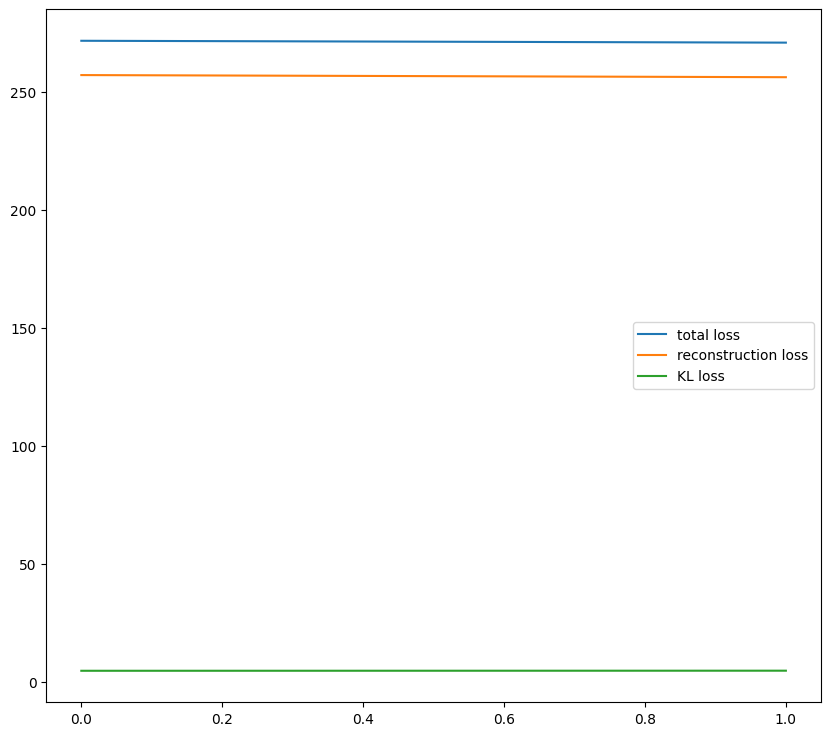

In [64]:
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('total_loss'), label="total loss")
plt.plot(history.history.get('ce_loss'), label="reconstruction loss")
plt.plot(history.history.get('k_l_loss'), label="KL loss")
plt.legend();

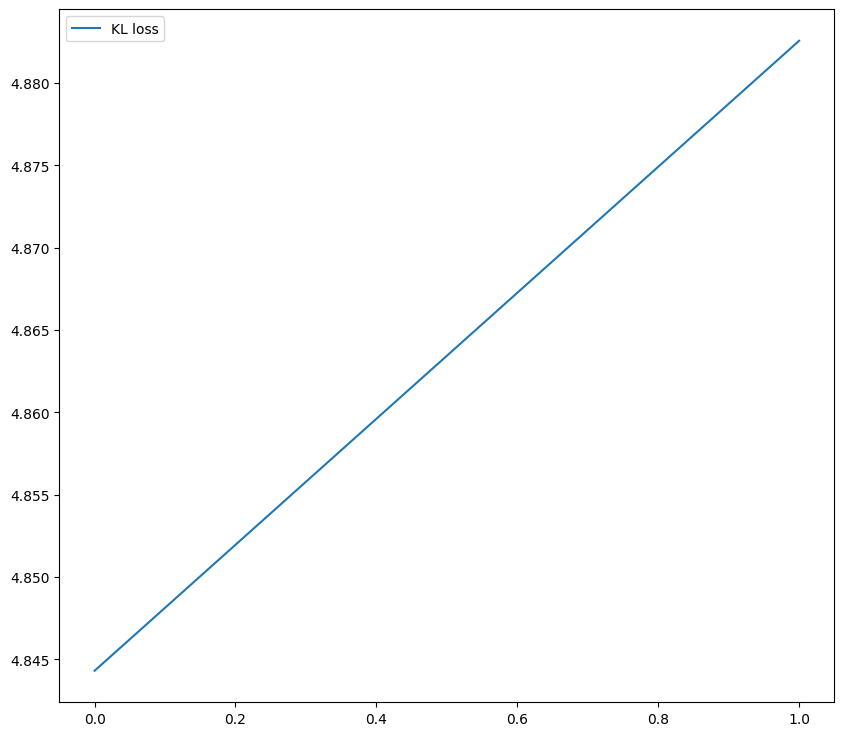

In [66]:
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('k_l_loss'), label="KL loss")
plt.legend();

1/1 [==============================] - 0s 72ms/step


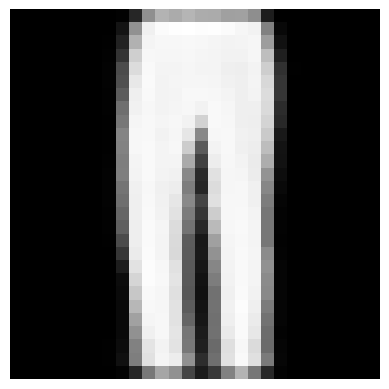

In [67]:
synth = vae.decoder.predict([[1, 2]])
plt.axis('off')
plt.imshow(synth.reshape((28,28)), cmap="Greys_r");

4/4 [==============================] - 0s 6ms/step


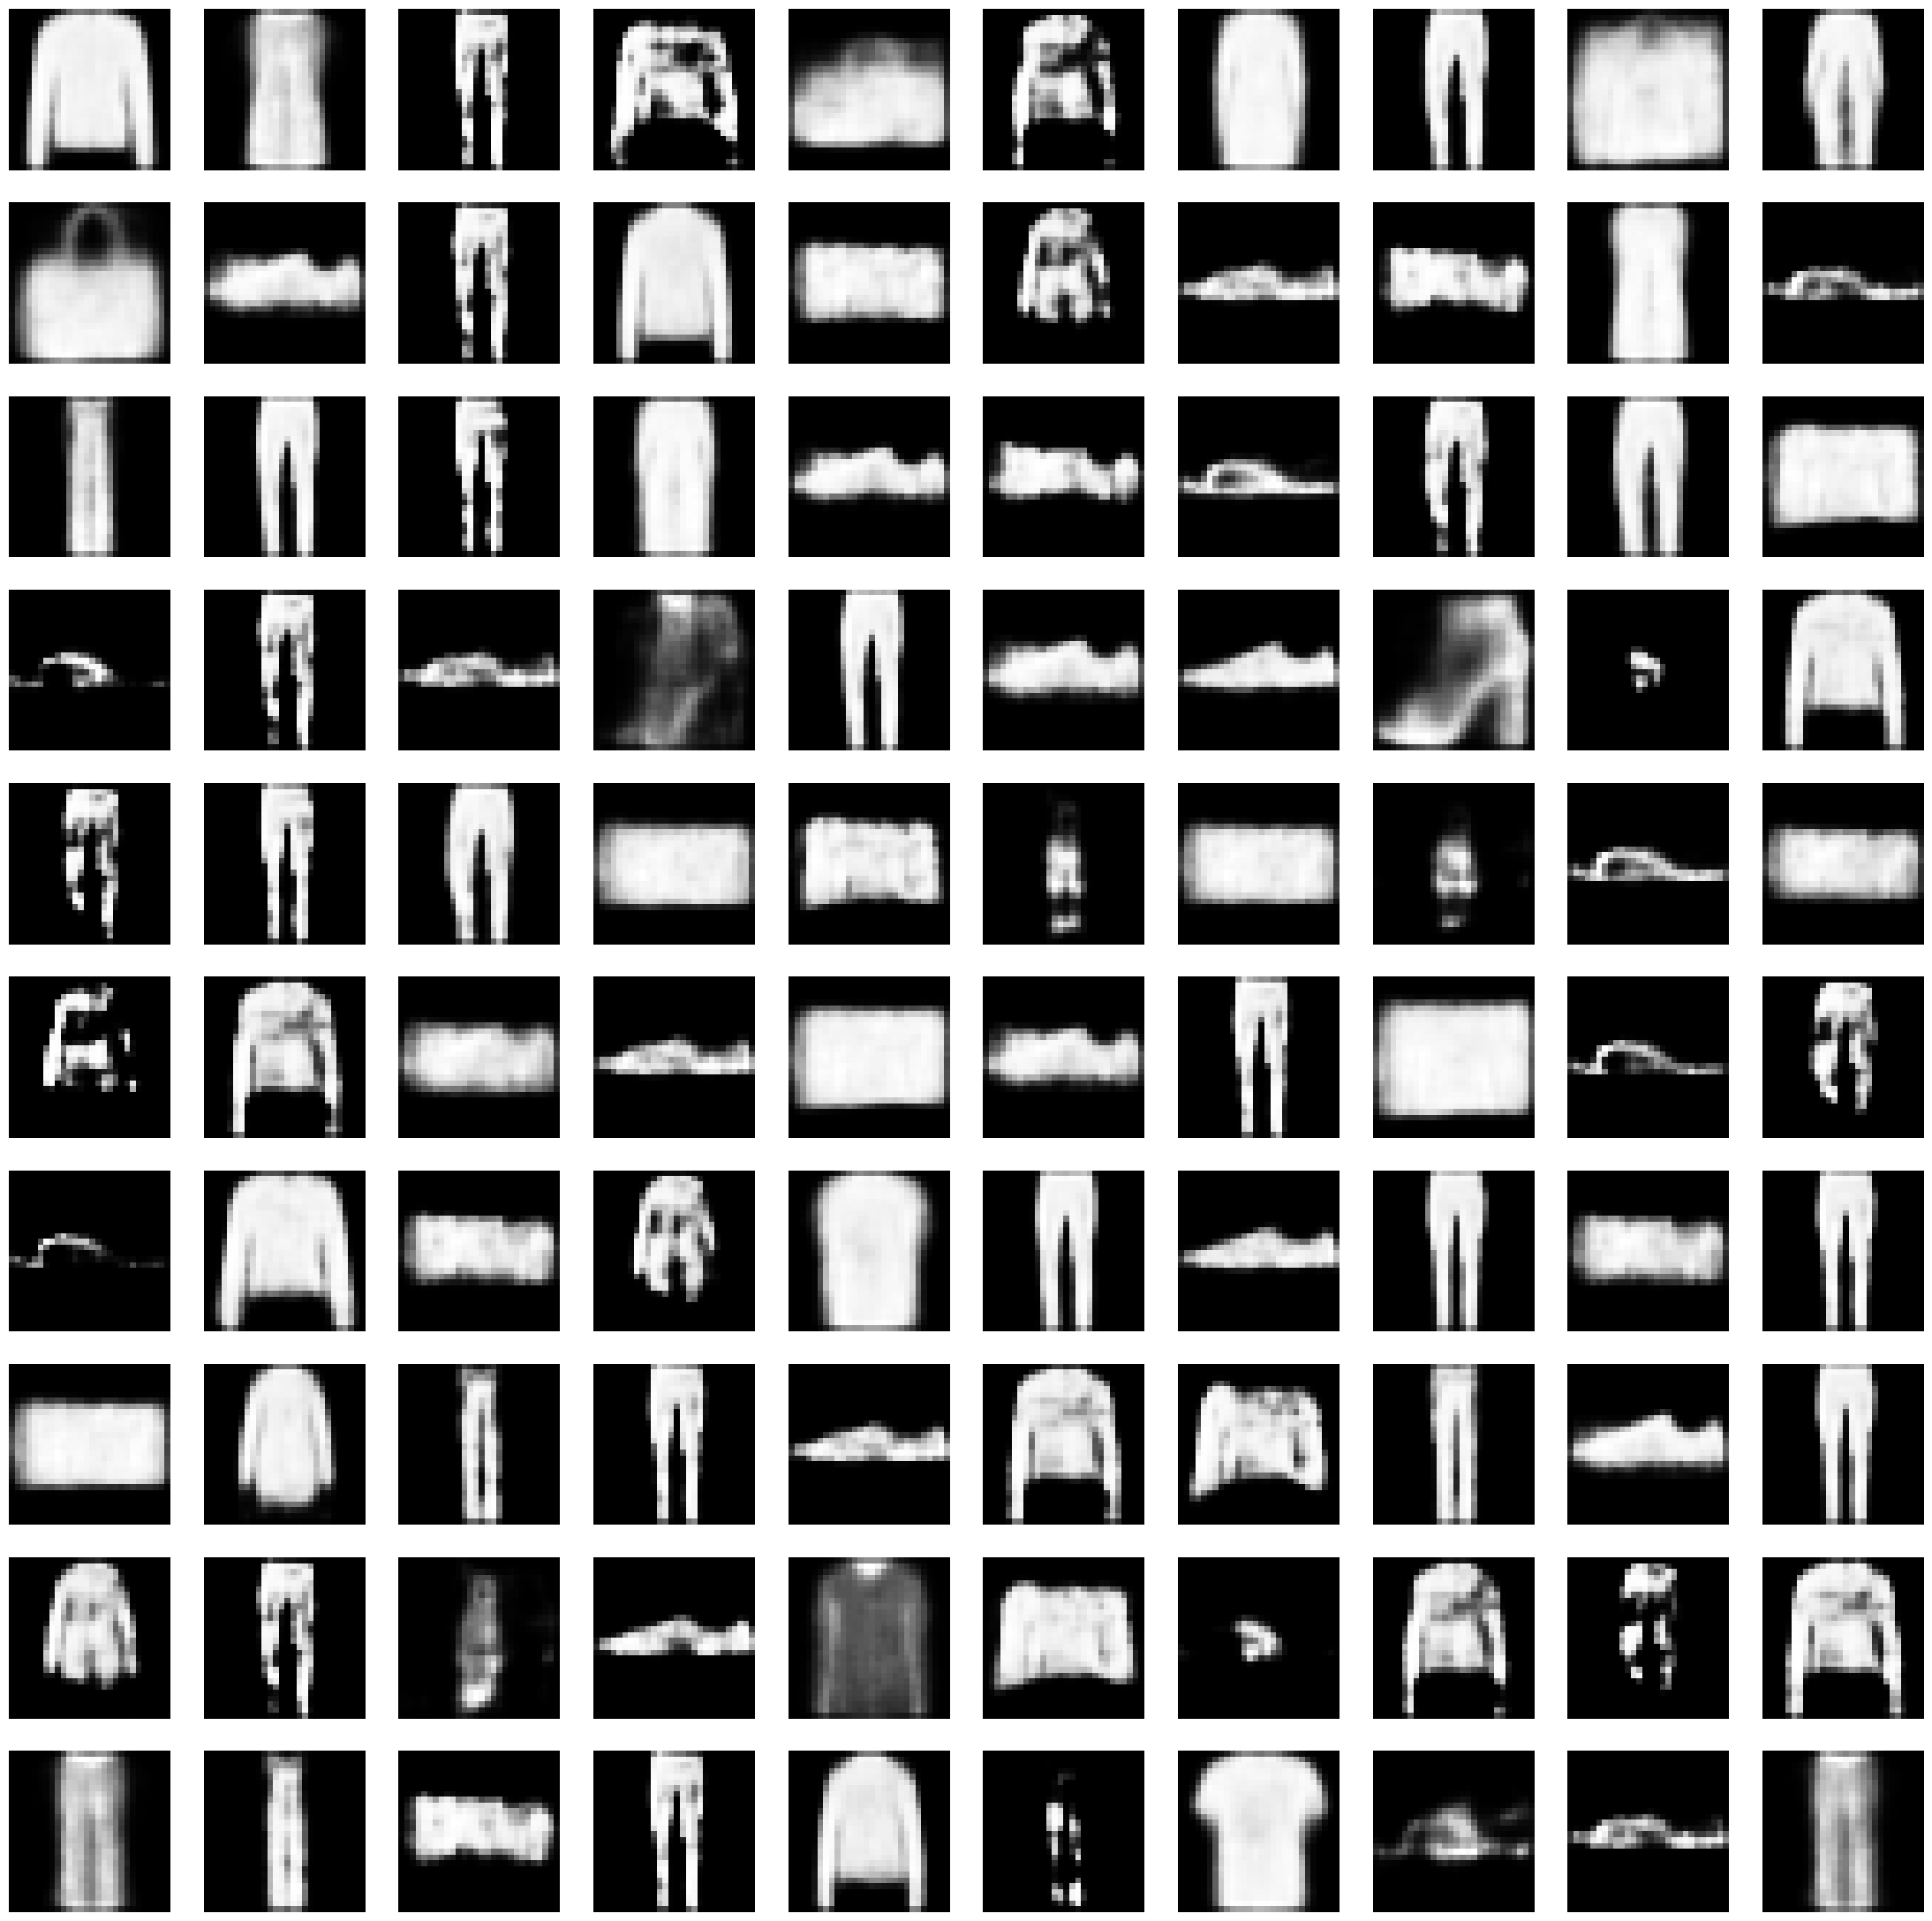

In [68]:
z = np.random.normal(loc=0, scale=4, size=(100,2))
synth = vae.decoder.predict(z)

plt.figure(figsize=(28,28))

for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(synth[i].reshape((28,28)), cmap="Greys_r")
    plt.axis('off')

plt.show();

In [69]:
idx = 1280 # arbitrariamente
batch = np.expand_dims(x_train[idx], axis=0)
batchOfImages = np.expand_dims(batch, axis=-1).astype("float32") / 255
print(batchOfImages.shape)

# obtém z(mu,sigma) para a imagem dada
_, _, z = vae.encoder.predict(batchOfImages)

# agora reconstrua uma imagem semelhante
synth = vae.decoder.predict([z])

z

(1, 28, 28, 1)
1/1 [==============================] - 0s 53ms/step


array([[0.91206014, 1.1223438 ]], dtype=float32)

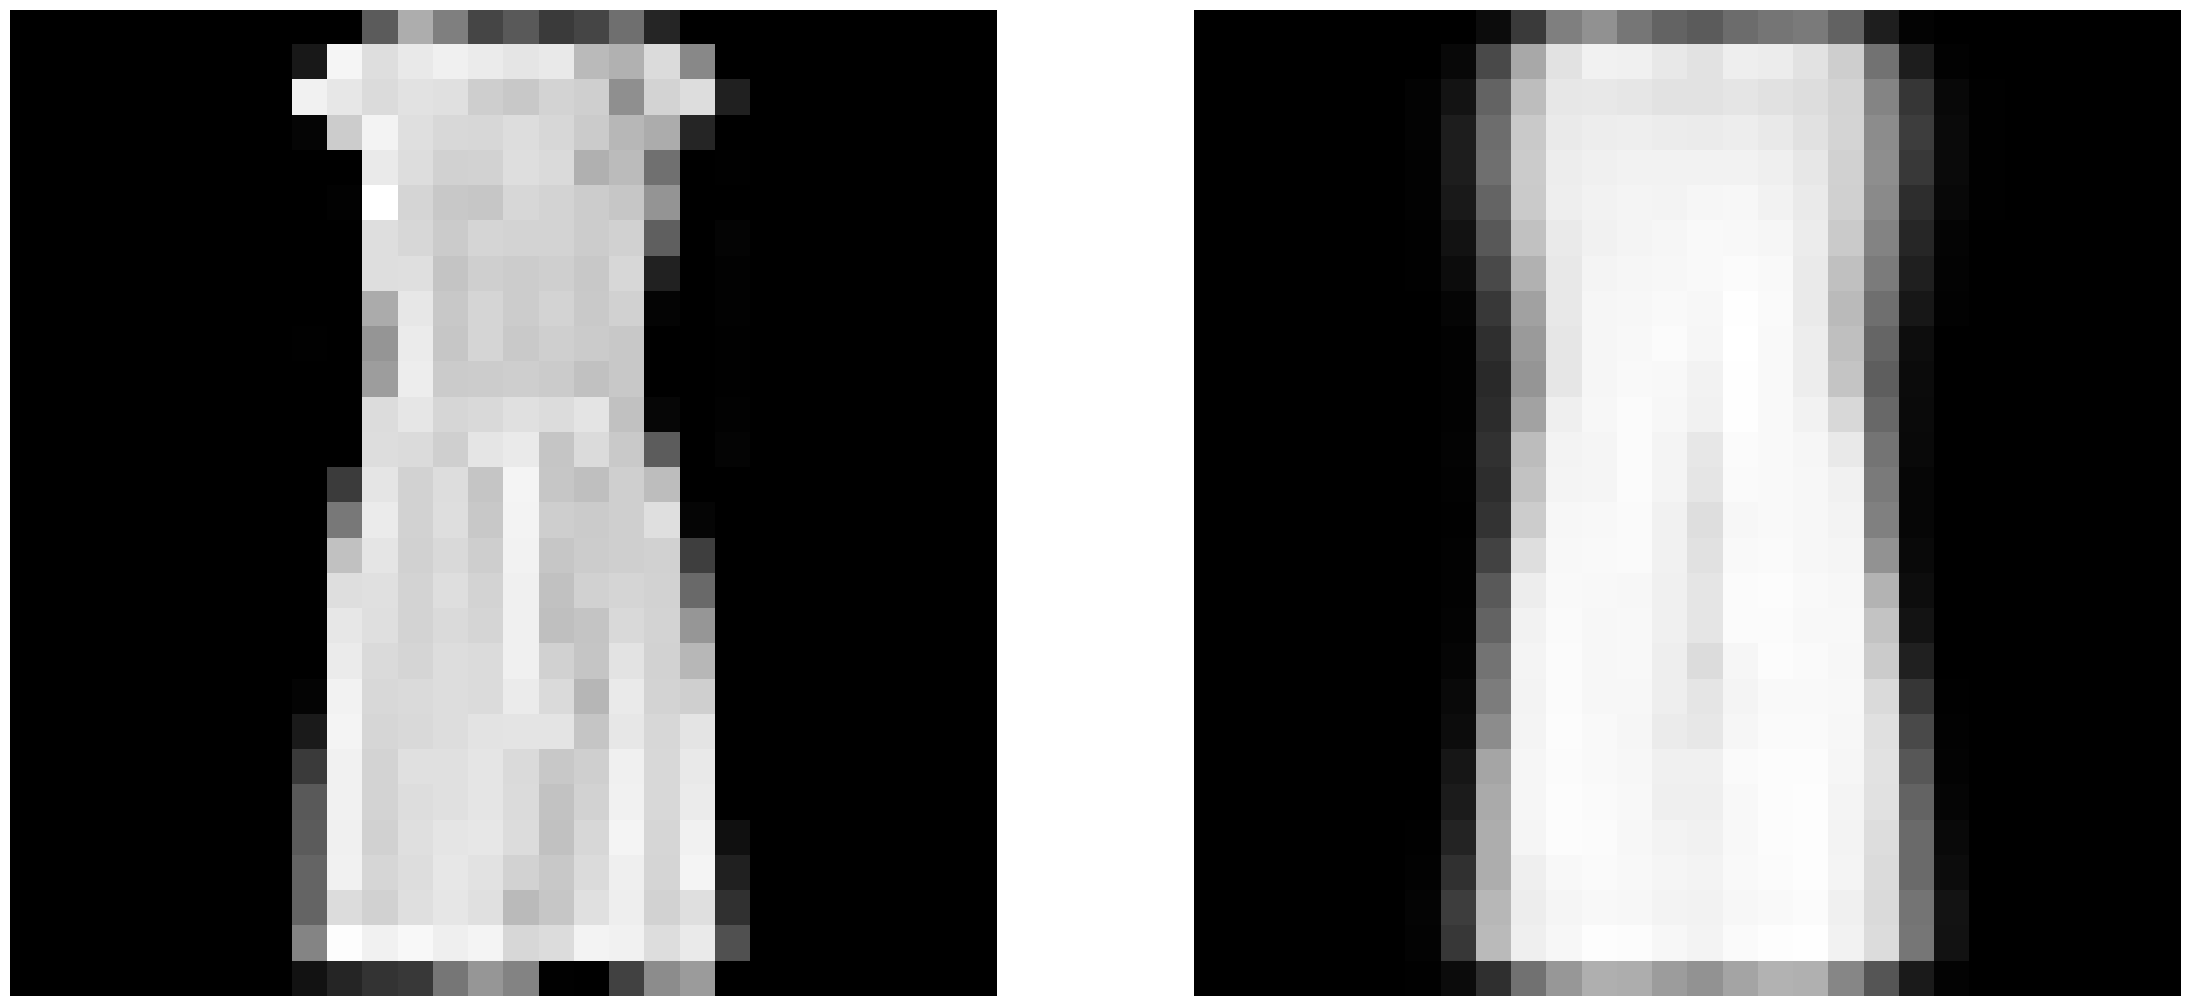

In [70]:
plt.figure(figsize=(28, 28))

# imagem original
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(x_train[idx], cmap="Greys_r")

# imagem reconstruída
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(synth[0].reshape((28,28)), cmap="Greys_r")
plt.show();

2188/2188 [==============================] - 4s 2ms/step


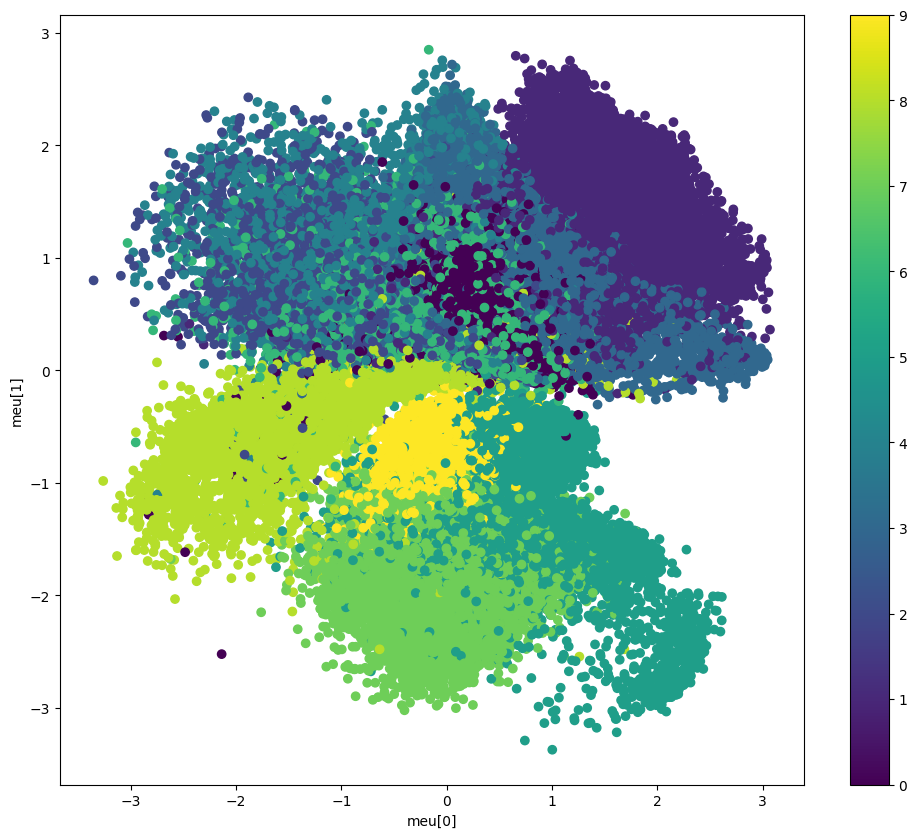

In [71]:
labels = np.concatenate([y_train, y_test], axis=0)
meu, _, _ = vae.encoder.predict(data)
plt.figure(figsize=(12, 10))
plt.scatter(meu[:, 0], meu[:, 1], c=labels)
plt.colorbar()
plt.xlabel("meu[0]")
plt.ylabel("meu[1]")
plt.show();